In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

from dataloader import prepare_data, create_generators, visualize_images


# Select classes and prepare data
classes = ["Angelina Jolie", "Brad Pitt", "Denzel Washington",
           "Hugh Jackman", "Jennifer Lawrence"]
prepare_data(classes)

# Create data generators
train_dir = "train_data"
test_dir = "test_data"
train_generator, test_generator = create_generators(train_dir, test_dir)

C:\Users\sarah\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 500 images belonging to 5 classes.
Found 395 images belonging to 5 classes.


In [2]:
from sklearn.metrics import roc_curve, auc

In [3]:
# Load the models
baseline_model = tf.keras.models.load_model('baseline_model.h5')
mobilenet_model = tf.keras.models.load_model('mobilenet_model.h5')
mobilenetv2_model = tf.keras.models.load_model('mobilenetv2_model.h5')

In [4]:
# Make predictions using all three models on the validation dataset
baseline_predictions = baseline_model.predict(test_generator)
mobilenet_predictions = mobilenet_model.predict(test_generator)
mobilenetv2_predictions = mobilenetv2_model.predict(test_generator)

C:\Users\sarah\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step


In [5]:
# Get true labels from the test generator
true_labels = test_generator.classes

In [9]:
import numpy as np

# Infer the number of classes from the shape of true labels or predictions
num_classes = len(np.unique(true_labels))
num_classes

5

In [10]:
from sklearn.metrics import roc_auc_score

# Calculate AUC scores for each class individually
baseline_auc_per_class = []
mobilenet_auc_per_class = []
mobilenetv2_auc_per_class = []

for class_index in range(num_classes):
    baseline_auc_per_class.append(roc_auc_score((true_labels == class_index).astype(int), baseline_predictions[:, class_index]))
    mobilenet_auc_per_class.append(roc_auc_score((true_labels == class_index).astype(int), mobilenet_predictions[:, class_index]))
    mobilenetv2_auc_per_class.append(roc_auc_score((true_labels == class_index).astype(int), mobilenetv2_predictions[:, class_index]))

print("Baseline Model AUC per Class:", baseline_auc_per_class)
print("MobileNet Model AUC per Class:", mobilenet_auc_per_class)
print("MobileNetV2 Model AUC per Class:", mobilenetv2_auc_per_class)


Baseline Model AUC per Class: [0.45377343374459217, 0.4842675725956483, 0.4981598317560463, 0.5355036565227649, 0.533728569139561]
MobileNet Model AUC per Class: [0.44500080115366125, 0.5423036479818814, 0.5115667718191378, 0.4700007863489817, 0.5496514981573466]
MobileNetV2 Model AUC per Class: [0.5152219195641724, 0.49126425624848336, 0.5319703955350642, 0.42799009200283084, 0.5164637077391443]


In [14]:
# Calculate mean ROC curves and standard deviations for each model
baseline_mean_fpr, baseline_mean_tpr = np.zeros(1000), np.linspace(0, 1, 1000)
mobilenet_mean_fpr, mobilenet_mean_tpr = np.zeros(1000), np.linspace(0, 1, 1000)
mobilenetv2_mean_fpr, mobilenetv2_mean_tpr = np.zeros(1000), np.linspace(0, 1, 1000)

baseline_auc_per_class = np.array(baseline_auc_per_class)
mobilenet_auc_per_class = np.array(mobilenet_auc_per_class)
mobilenetv2_auc_per_class = np.array(mobilenetv2_auc_per_class)

for i in range(num_classes):
    baseline_mean_fpr, baseline_mean_tpr, _ = roc_curve(true_labels, baseline_predictions[:, i], pos_label=i)
    mobilenet_mean_fpr, mobilenet_mean_tpr, _ = roc_curve(true_labels, mobilenet_predictions[:, i], pos_label=i)
    mobilenetv2_mean_fpr, mobilenetv2_mean_tpr, _ = roc_curve(true_labels, mobilenetv2_predictions[:, i], pos_label=i)


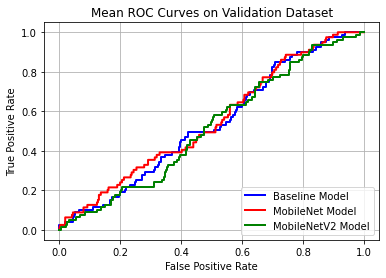

In [15]:
# Plot mean ROC curves
plt.plot(baseline_mean_fpr, baseline_mean_tpr, color='blue', lw=2, label=f'Baseline Model')
plt.plot(mobilenet_mean_fpr, mobilenet_mean_tpr, color='red', lw=2, label=f'MobileNet Model')
plt.plot(mobilenetv2_mean_fpr, mobilenetv2_mean_tpr, color='green', lw=2, label=f'MobileNetV2 Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curves on Validation Dataset')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()